<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>

<!--[image.png](attachment:image.png) -->

# Wstęp do uczenia maszynowego -- Notebook 6, version for students
**Author: Dorota Celińska-Kopczyńska, Michał Ciach**  


## Description


In today's class, we will work with the model's diagnostics. We will be checking whether the linear regression assumptions are satisfied in our sample datasets. We will also discuss the individual and joint significance of the parameters in our model and look for any influential observations.

The importance of the diagnostics depends on the focus of our model. Generally, while working with linear regression, we may be primarily interested in either a) interpretability or b) prediction. If our main focus is interpretability, we have to pay special attention to the properties of the OLS estimator such as unbiasedness or efficiency. In such a situation, diagnostics is a must, i.e., if some assumptions are not satisfied in our model, the interpretability will be questionable. On the other hand, even a model that does not satisfy all assumptions may be beneficial for prediction.  

The assumptions we will check can be summarized as the LINE rule:    

- **L**inear trend,
- **I**ndependent residuals (lack of autocorrelation),
- **N**ormally distributed residuals,
- **E**qual variance of residuals for all values of independent variables (homoscedasticity).

We will check them visually by creating and analyzing the following diagnostic plots:   

- The residual value vs the fitted value,
- The root square of the absolute value of standardized residuals vs the fitted value,
- The line plot of the residuals,
- Graphical analysis of the distribution of the residuals (histogram, boxplots, qq-plot).

The first plot is used to check if the relationship between the response (the dependent variable) and the predictors (the independent variables) is linear and to very roughly check if the residuals are uncorrelated. We expect values distributed symmetrically across the line $y=0$. However, this plot may be misleading if a non-spherical random disturbance occurs. That is why we encourage performing the Ramsey RESET test.  

The second plot checks the variance's homoscedasticity (equality for all values of the independent variables). We expect values to be distributed symmetrically across a straight horizontal line.

The third plot allows you to determine if your model has problems with autocorrelation (or heteroscedasticity). We expect to see a plot resembling a sound wave of constant amplitude (homoscedasticity) and no trend (lack of autocorrelation).

The histogram is used to visualize the distribution of residuals. You can also use a qq-plot if you know how to create and interpret it.

While the above are the assumptions of the classical linear regression model, some problems with data might still occur and may significantly reduce the quality of the results obtained with OLS. That is why, in the later part of this notebook, we will also address the issues of multicollinearity and influential observations and how to find them. For the detection of the multicollinearity, we will use VIF. Finally, we will inspect either the influence plot or the leverage-resid2 plot,  implemented in [`statsmodels`](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html). Both plots are used to detect outliers that highly influence the model parameters.

In [1]:
!pip install gdown
!pip install --upgrade gdown
!gdown https://drive.google.com/uc?id=1PjeSdrN9E0fzs3J0zVT7P7a1PT1vMDZ6
!gdown https://drive.google.com/uc?id=1vne1N6D0yov8lrp9kCo1qZoT61CXYL6P
!gdown https://drive.google.com/uc?id=1k0iAQYLdppDQUBmKPZ0ckSNLNv9izwZU

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From: https://drive.google.com/uc?id=1PjeSdrN9E0fzs3J0zVT7P7a1PT1vMDZ6
To: /content/6. BDL municipality area km2 2015-2020.csv
100% 180k/180k [00:00<00:00, 79.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vne1N6D0yov8lrp9kCo1qZoT61CXYL6P
To: /content/6. BDL municipality incomes 2015-2020.csv
100% 228k/228k [00:00<00:00, 78.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k0iAQYLdppDQUBmKPZ0ckSNLNv9izwZU
To: /content/6. BDL municipality population 2015-2020.csv
100% 222k/222k [00:00<00:00, 84.5MB/s]


## Data & library imports

In [46]:
import pandas as pd
import plotly.express as px
import numpy as np
import statsmodels.api as sm
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import svd

import statsmodels.formula.api as smf


In [4]:
income = pd.read_csv('6. BDL municipality incomes 2015-2020.csv', sep=';', dtype={'Code': 'str'})
population = pd.read_csv('6. BDL municipality population 2015-2020.csv', sep='\t', dtype={'Code': 'str'})
area = pd.read_csv('6. BDL municipality area km2 2015-2020.csv', sep='\t', dtype={'Code': 'str'})

In [5]:
voivodeship_names = {
    '02': 'Dolnośląskie',
    '04': 'Kujawsko-pomorskie',
    '06': 'Lubelskie',
    '08': 'Lubuskie',
    '10': 'Łódzkie',
    '12': 'Małopolskie',
    '14': 'Mazowieckie',
    '16': 'Opolskie',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomorskie',
    '24': 'Śląskie',
    '26': 'Świętokrzyskie',
    '28': 'Warmińsko-mazurskie',
    '30': 'Wielkopolskie',
    '32': 'Zachodniopomorskie'
}

In [6]:
code_list = [s[:2] for s in income["Code"]]
name_list = [voivodeship_names[code] for code in code_list]
income['Voivodeship'] = name_list

## Diagnostics when assumptions are satisfied

**Exercise 1.** In this exercise, we will inspect the diagnostics of the model when the assumptions of the linear regression model are satisfied. We will focus on artificial data with a given multidimensional distribution and correlation matrix. Our variables are not highly correlated with each other. We consider a model in which y will be the dependent variable (response), and A, B, C, and the constant will be the independent ones (predictors).

The code below shows you how to generate data from a multivariate normal distribution. In [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), you will find the function `rvs()`, which samples from a multivariate normal distribution. We need to specify the means of the variables and the covariance matrix (note that we provide variances on the diagonal of the matrix). For the replicability of the results, we also specify the seed -- this way every time you run this code, you will get exactly same result.

In [7]:
# generate the artificial data -- X matrix
# construct the covariance matrix
cov = np.array([[1.0, 0.0, 0.0],[0.0,25.0,4.0],[0.0,4.0,25.0]])
cov

# set the seed for reproducibility
np.random.seed(17042023)

df = mvn.rvs(mean = [0.0,20.0,20.0], cov=cov, size = 1000)

X = pd.DataFrame(df, columns=['A', 'B', 'C'])
X

,A,B,C
0,-0.532916,16.620824,28.073368
1,-1.161948,19.691948,24.804271
2,-1.273844,29.581994,22.408298
3,0.503258,15.383174,20.189613
4,-1.690212,19.044991,21.150642
...,...,...,...
995,0.111524,26.035274,29.831282
996,0.218465,26.525677,26.933461
997,1.709178,20.282076,24.463412
998,-0.735846,14.871768,23.165358


Our data are generated according to the linear model: $y = 0.4A + 0.5B + 0.5C + \varepsilon$. Note that this will be our ground truth -- the scenario we know is true, and we will compare against.

In [ ]:
# generate artificial data -- Y
Y = 0.4*X['A'] + 0.5*X['B'] + 0.5*X['C'] + np.random.normal(0,1,1000)
Y = pd.DataFrame(Y, columns=['Y'])
Y

,Y
0,22.108560
1,20.747533
2,25.044710
3,18.673974
4,20.562017
...,...
995,27.743788
996,25.494648
997,23.264963
998,18.194311


**Exercise 1a**. Inspect the descriptive statistics of the data set.
Visualize the relationships between dependent and independent variables.

*Hint:* for a convenient preparation of scatterplots for all of the pairs of the variables in your dataset, you may use [`scatter_matrix`](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_matrix.html) from `plotly.express`.

In [ ]:
px.scatter_matrix(Y.join(X))

**Exercise 1b** Estimate the model and inspect its summary. Are the variables jointly significant according to the F-test? Are all individual variables significant according to the t-test? Compare the estimates' values with the parameters' true values (from the ground truth).

Hint: Not that the intercept is not included by default and we need to modify our dataset with [sm.add_constant()](https://www.statsmodels.org/dev/generated/statsmodels.tools.tools.add_constant.html).

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     5146.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:54:54   Log-Likelihood:                -1409.5
No. Observations:                1000   AIC:                             2827.
Df Residuals:                     996   BIC:                             2847.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1725      0.163      1.057      0.2

**Exercise 1c** Inspect the output of [get_prediction().summary_frame()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.base.prediction.PredictionResults.summary_frame.html). Do you know what is in the `mean` and `mean_se` columns? Do you understand the difference `mean_ci` and `obs_ci` (*Mean Confidence Interval* and *Observation Prediction Interval*)?

Use the summary frame data to compute the residuals $\hat{\epsilon}_i = Y_i - X_i\hat{\beta}$. Calculate the standardized residuals $(\hat{\epsilon}_i - \text{mean}(\hat{\epsilon}))/\text{sd}(\hat{\epsilon})$, and square roots of absolute values of standardised residuals.

In [ ]:
prediction_results = results.get_prediction().summary_frame()
print(prediction_results)

          mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0    22.080564  0.071132      21.940979      22.220149     20.127690   
1    21.759805  0.058000      21.645989      21.873622     19.808604   
2    25.473131  0.078058      25.319953      25.626309     23.519239   
3    17.984468  0.045396      17.895386      18.073551     16.034553   
4    19.433164  0.062276      19.310958      19.555370     17.481455   
..         ...       ...            ...            ...           ...   
995  27.895102  0.074353      27.749195      28.041009     25.941766   
996  26.754925  0.063317      26.630674      26.879176     24.803087   
997  23.001819  0.068028      22.868325      23.135313     21.049371   
998  18.712742  0.057511      18.599885      18.825599     16.761597   
999  22.156200  0.069515      22.019788      22.292612     20.203551   

     obs_ci_upper  
0       24.033438  
1       23.711007  
2       27.427024  
3       19.934383  
4       21.384873  
..            .

In [ ]:
results.predict(X)

0      22.080564
1      21.759805
2      25.473131
3      17.984468
4      19.433164
         ...    
995    27.895102
996    26.754925
997    23.001819
998    18.712742
999    22.156200
Length: 1000, dtype: float64

In [ ]:
residuals = Y['Y'] - results.predict(X)
residuals_mean = residuals.mean()
residuals_sd = residuals.std()

residuals

0      0.027996
1     -1.012272
2     -0.428422
3      0.689506
4      1.128853
         ...   
995   -0.151314
996   -1.260277
997    0.263144
998   -0.518431
999    0.585112
Length: 1000, dtype: float64

In [ ]:
results.resid

0      0.027996
1     -1.012272
2     -0.428422
3      0.689506
4      1.128853
         ...   
995   -0.151314
996   -1.260277
997    0.263144
998   -0.518431
999    0.585112
Length: 1000, dtype: float64

**Linear functional form**

Based on the ground truth model that we used (we know how $y$ was generated), we know that the linear functional form assumption is satisfied.

In practice we would use the [Ramsey RESET test](https://en.wikipedia.org/wiki/Ramsey_RESET_test) (Regression Specification Error Test) to check that the model's functional form is correct, with:

$$H_0:X\beta+\varepsilon$$
$$H_1:f(X\beta)+\varepsilon$$

where f() is non-linear. Important: The functional form's linearity applies to the coefficients' powers; the x-variables can be transformed freely. There are several versions of this test. The version presented here estimates the original regression and obtains the fitted values. An auxiliary regression is then estimated in which successive powers of the fitted values from the primary regression become the independent variables. We test for joint insignificance of the estimated coefficients at powers greater than 1 of the fitted values in the auxiliary regression.

Interestingly, a similar idea to the RESET test can be used to test the functional form in other models. A generalized version of this test is called the link test.

In [ ]:
# Results of RESET test
print(sm.stats.diagnostic.linear_reset(results, power=3, test_type='fitted'))

<Wald test (chi2): statistic=0.7022620738542251, p-value=0.7038915120314531, df_denom=2>


The p-value in the RESET test is higher than any standard significance level, so we support the null hypothesis. Note that RESET is designed for small-sized samples -- if the sample is big enough, it tends to reject the null hypothesis.

**Exercise 1d** Prepare the first type of diagnostic plots, i.e., plot the residual values vs the fitted values, e.g., using `px.scatter()`. If the assumptions are satisfied, you should see a cloud of points and no trend and the data would be evenly distributed along the horizontal line (add such a line to the graph).

In [ ]:
fig = px.scatter(x = results.predict(X), y = residuals, labels={'x': 'Fitted Values', 'y': 'Residuals'},
                 title='Residuals vs Fitted Values')

fig.add_hline(y=0, line_color="red")

A useful tweak to this plot is to add a trend line visualizing the relationship between the fitted values and the residuals. This can be easily done with [seaborn.regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html). If the assumptions about linearity are satisfied, you should see a line as close to a horizontal one as possible (minor deviations are acceptable).

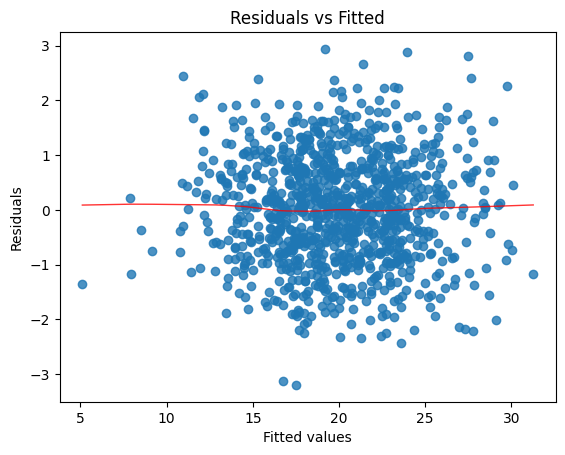

In [ ]:
from statsmodels.graphics.gofplots import ProbPlot
import seaborn as sns
import matplotlib.pyplot as plt

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid

# here we use matplotlib
# with sns.residplot
# we draw the scatterplot of residuals against the fitted values (scatter=True)
# and we add a regression line
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.regplot(x=model_fitted_y, y=model_residuals,
                                scatter=True,
                                ci=False,
                                lowess=True,
                                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

**Assumptions about the random disturbance (error term)**

We check the assumptions about the behavior of the distribution of the random disturbance (error term) based on the residuals. Note that we know the relationship between the residuals and the random component thanks to the idempotent matrix M -- the theory presented in the lecture.

***Expected value of the random disturbance***

If the model contains the constant term, there is no need to check the assumption about the expected value of the random disturbance being zero. Because of the properties of the regression hyperplane, the sum of the residuals is zero in the models with constant terms. The mean of the residuals will also be zero, so it is reasonable to use the mean as an estimate of the expected value in this case.

**Exercise 1e** Compare the mean of the residuals in the model with and without the constant. Due to the finite precision of the calculations, you will get a non-zero value in both cases, but this value will be much lower (in terms of absolute values) in the model with a constant.

In [ ]:
# put your code here


Summary with constant:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     5146.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:42:27   Log-Likelihood:                -1409.5
No. Observations:                1000   AIC:                             2827.
Df Residuals:                     996   BIC:                             2847.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1725      0.

***Normality of the distribution of the random disturbance***

We can verify this (additional!) assumption with the graphical analysis of the distributions of the residuals. Graphical analysis of residuals can be done in several ways:

* Histogram/kernel density plot (density plot)
* Quantile-quantile chart
* Boxplot (boxplot)


As here we are working with a relatively large sample -- it is not surprising that we can expect that, under CLT, the distributions of statistics will converge to standard ones.

**Exercise 1f** Inspect the distributions of the residuals in your favorite way. For example, draw the histogram or a qq-plot (see [statsmodels.graphics.gofplots.qqplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) and explanation [here](https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html) and [here](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot)) of the residuals. There should be no significant differences between the empirical and the trend line in the qq-plot, and the histogram should resemble the bell curve. Compare your insights with the conclusion from the Shapiro-Wilk test (e.g., from `scipy.stats`).

In [ ]:
# put your code here (histogram)


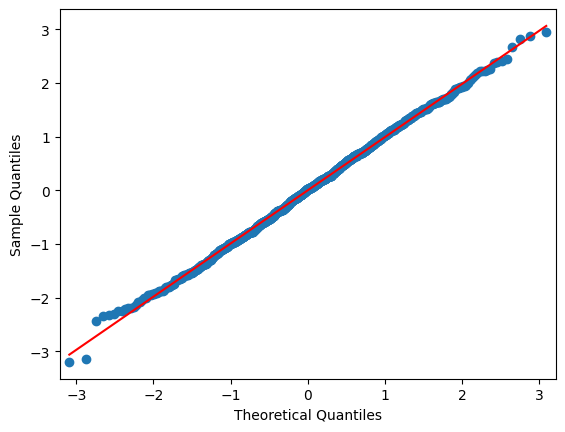

In [ ]:
# put your code here (qq-plot)


In [ ]:
# put your code here


ShapiroResult(statistic=0.9984365105628967, pvalue=0.5138406753540039)

***Homoscedasticity and the lack of autocorrelation***

Here, we will use two types of plots: (1) square root of standardized residuals vs the fitted values (also known as scale vs location) and (2) line plot of residuals against the number of observations.

Let us start with the first type of plots for checking homoscedasticity and lack of autocorrelation: **scale vs location** plot. If the assumptions about the sphericity of the random disturbance are satisfied, we should see a cloud of data in the first graph. If you see triangular shapes of the data clouds, it indicates heteroscedasticity.

**Exercise 1g** Prepare the **scale vs location diagnostic plot**. Plot the squared standardized residuals against the fitted values. Compare with the insights from the first diagnostic plot.

In [ ]:
# put your code here


However, the plot above may be tricky to interpret. That is why you may see a 'tweaked' version of this plot, as shown in the code below. We add a trend line (similarly to the first diagnostic plot) for visibility.

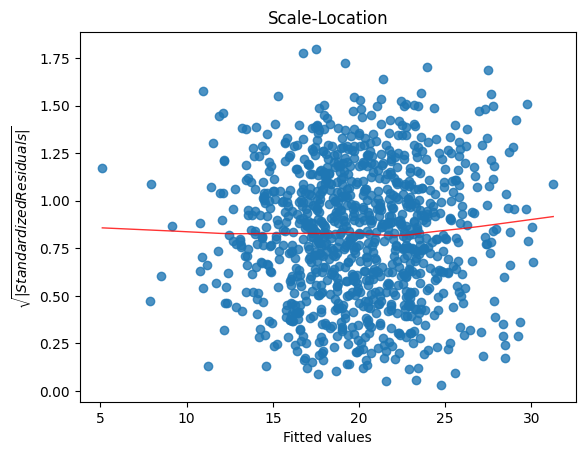

In [ ]:
from statsmodels.graphics.gofplots import ProbPlot
import seaborn as sns
import matplotlib.pyplot as plt

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

plot_lm_2 = plt.figure()
sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_2.axes[0].set_title('Scale-Location')
plot_lm_2.axes[0].set_xlabel('Fitted values')
plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

 The more horizontal the red line is, the more likely the data is homoscedastic.
If the trend line is horizontal or deviates only slightly, "it's fine." In our case, we see a slight positive deviation between the low and high fit values. However, these are negligible fluctuations. In Exercise 2, you will be able to compare how the trendline behaves when problems occur.

As for the second type of plot for checking homoscedasticity and lack of autocorrelation -- **line plot of residuals against the number of observations** -- it allows you to inspect if there are (particularly) problems with autocorrelation. However, you can also spot heteroscedasticity there. If the assumptions about the sphericity of the random component are satisfied, you should see something that resembles a plot of a sound wave with a constant amplitude. The fluctuations should be around zero. Single stronger fluctuations are not a problem.

The problems occur if, for example:
- the amplitude of fluctuations increases (you see a funnel) -- the variance is not constant (heteroscedasticity),
- you notice a trend -- there is autocorrelation,
- periods of high amplitude alternate with periods of low -- unstable variance, "variance clustering" (heteroscedasticity),
- the values do not oscillate around one value -- for example, there is an alternating trend, the graph resembles a sine wave (autocorrelation).

The above list, of course, does not exhaust all possible problems.

**Exercise 1h** Prepare the another diagnostic plot: **the line plot of the residuals against the number of observations**. For convenience, add a horizontal line through zero.

In [ ]:
# put your code here


**Lack of multicolinearity and influential observations**

The last thing -- we need to check if we have the problem of multicollinearity in our model and if there are influential observations. Typically, we say there is a problem if the VIF is about 10 (or the mean VIF is about 10).

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

#calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

  feature        VIF
0   const  27.041285
1       A   1.001506
2       B   1.055968
3       C   1.056682


**Exercise 1i** Interpret the value of VIF in this model.

**Exercise 1j** Find out if there are influential observations (deleating them would noticeably change the model) in the model with `sm.graphics.influence_plot()`. You should be worried if you see the observations in the top right or bottom right part of the plot (this means those observations have, at the same time, high [leverages](https://en.wikipedia.org/wiki/Leverage_(statistics)) and standardized residuals).

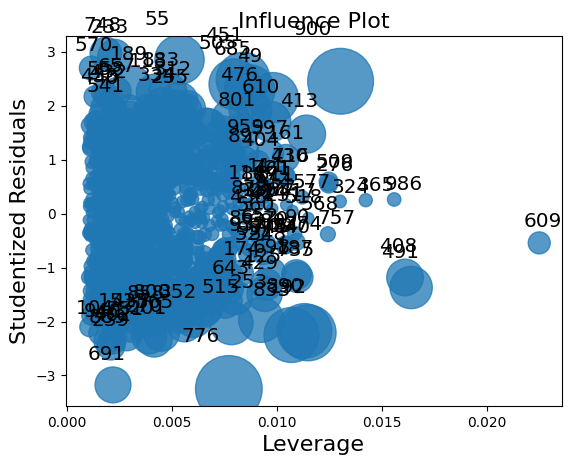

In [ ]:
sm.graphics.influence_plot(results, criterion="cooks").show()

## Determining which assumptions are not satisfied

**Exercise 2.** Find out what problems (if any) exist in those models. $n$ is the number of observations, and $k$ is the number of the parameters in the model (including the constant term).

a) n = 204, k = 3
<center><img src='https://mimuw.edu.pl/~dot/resources/wum/diag1.png'>
    </center>

1. Reszty nie są jednorodne
2. Ogony są oczekiwane - są to skrajne, ekstremalne wartości które trudno oszacować
3. Wykres wskazuje na autokorelacje

b) n = 1000, k = 4
<center><img src='https://mimuw.edu.pl/~dot/resources/wum/diag2.png'>
    </center>

1. Dlatego reszty nazywamy sferyczne (Dobre reszty nie powinny się grupować)

Reszta wykresów wygląda poprawnie


c) n = 1000, k = 4
<center><img src='https://mimuw.edu.pl/~dot/resources/wum/diag3.png'>
    </center>

1. Środkowe wartości mają statycznie większe reszty - czyli pogrupowaliśmy reszty - źle
2.  

d) n = 500, k = 4
<center><img src='https://mimuw.edu.pl/~dot/resources/wum/diag4.png'>
    </center>

 e) n = 340, k = 2
<center><img src='https://mimuw.edu.pl/~dot/resources/wum/diag5.png'>
    </center>

**Exercise 3 (homework)** In this exercise, we will predict the income of a municipality in 2020 based on its population and voivodeship.

Create a dataframe with the territorial code, income, population, and voivodeships of municipalities in 2020 using `pd.merge()` to perform a join with the `Code` variable as the key. Remove rows with missing values.
Use the `pd.get_dummies()` function to encode the voivodeship for each municipality with dummy variables.

Estimate the model and inspect its summary.
Are the variables jointly significant according to the F-test?
Are all individual variables significant according to the t-test? What are the interpretations of the parameters?
Can you use a model with intercept in this exercise? Why / why not? If yes, what is its interpretation?

Conduct the diagnostics of the model. Decide which assumptions are satisfied to an appropriate degree.
If you detect an outlying observation, remove it from the data set, rerun the calculations and diagnostics and check if it improves the model fit.

If you detect heteroskedasticity (non-constant variance of residuals), transforming the data may help.
You may transform both the dependent and independent variables.
Transforming the latter changes the functional relationship between the variables (i.e., whether they are linearly related), while transforming the former changes both the relationship and the residual variance structure.

Estimate the average error in PLN that you would make if you used your model to predict a municipality's income from its population.

In [65]:
income_population = income[['Code', 'Region', 'Voivodeship', '2020']].merge(
    population[['Code', '2020']], how='inner', on='Code', suffixes=('_income', '_population'))
income_population = income_population.dropna()
income_population.rename({'2020_income':'income', '2020_population':'population'}, axis=1, inplace=True)

In [68]:
mod = smf.ols(formula='income ~ population + C(Voivodeship)', data=income_population)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     2381.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:55:41   Log-Likelihood:                -48400.
No. Observations:                2477   AIC:                         9.683e+04
Df Residuals:                    2460   BIC:                         9.693e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -3.663e+07   5.74e+06     -6.381      0.000   -4.79e+07   -2.54e+07
C(Voivodeship)[T.Kujawsko-pomorskie]  -5.534e+06   8.43e+06     -0.656      0.512   -2.21e+07     1.1e+07
C(Voivodeship)[T.Lubelskie]            2.574e+06   7.66e+06      0.336      0.737   -1.24e+07    1.76e+07
C(Voivodeship)[T.Lubuskie]             1.281e+06      1e+07      0.128      0.898   -1.83e+07    2.09e+07
C(Voivodeship)[T.Mazowieckie]          1.218e+07   7.09e+06      1.717      0.086   -1.73e+06    2.61e+07
C(Voivodeship)[T.Małopolskie]          -1.46e+07   7.94e+06     -1.839      0.066   -3.02e+07    9.71e+05
C(Voivodeship)[T.Opolskie]            -3.254e+06   1.05e+07     -0.309      0.757   -2.39e+07    1.74e+07
C(Voivodeship)[T.Podkarpackie]        -7.883e+06    8.2e+06     -0.961      0.337    -2.4e+07     8.2e+06
C(Voivodeship)[T.Podlaskie]            6.709e+06   8.92e+06      0.752      0.452   -1.08e+07    2.42e+07
C(Voivodeship)[T.Pomorskie]           -6.145e+06   8.81e+06     -0.697      0.486   -2.34e+07    1.11e+07
C(Voivodeship)[T.Warmińsko-mazurskie] -2.134e+06   8.97e+06     -0.238      0.812   -1.97e+07    1.54e+07
C(Voivodeship)[T.Wielkopolskie]        -4.11e+06   7.56e+06     -0.544      0.587   -1.89e+07    1.07e+07
C(Voivodeship)[T.Zachodniopomorskie]   2.165e+06   9.03e+06      0.240      0.811   -1.56e+07    1.99e+07
C(Voivodeship)[T.Łódzkie]              9.848e+05      8e+06      0.123      0.902   -1.47e+07    1.67e+07
C(Voivodeship)[T.Śląskie]             -2.646e+07   8.12e+06     -3.260      0.001   -4.24e+07   -1.05e+07
C(Voivodeship)[T.Świętokrzyskie]      -3.285e+06   9.32e+06     -0.352      0.725   -2.16e+07     1.5e+07
population                             5707.0585     29.308    194.728      0.000    5649.588    5764.529
==============================================================================
Omnibus:                     4212.371   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22083945.340
Skew:                          10.605   Prob(JB):                         0.00
Kurtosis:                     465.087   Cond. No.                     8.49e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

                            OLS Regression Results                            
Dep. Variable:             2020income   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     2381.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:42:30   Log-Likelihood:                -48400.
No. Observations:                2477   AIC:                         9.683e+04
Df Residuals:                    2460   BIC:                         9.693e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
2020popula

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1



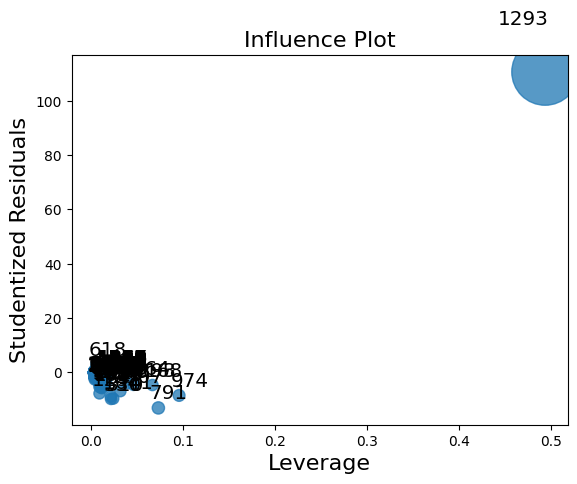

In [ ]:
# put your code here


## Multicollinearity and omitted variables

**Exercise 4.**  In this exercise, we will show what may happen to our statistical reasoning and the estimates of the parameters if we have multicollinearity in our model or we did not include a significant variable. We will again work with artificial data.

**Exercise 4a** Generate the data ($n=1000$) in a way similar to the one shown in Exercise 1. Our dataset contains the following variables:

- A, which is not correlated with the others, $\mu=0, \sigma^2=1$
- B and C, which are highly correlated (covariance = 24.9875), both with $\mu=20, \sigma^2=25$
- D that will be correlated with variable C (covariance = 8.0), and with B (covariance = 7.99), $\mu=4, \sigma^2=4$

Use seed 23033023.

In [ ]:
# put your code here


,A,B,C,D
0,-0.114443,27.492540,27.312639,5.866607
1,1.066463,29.292654,29.483031,5.908330
2,1.294435,22.310019,22.259246,6.161364
3,0.067786,25.236408,25.373602,3.694821
4,0.606186,18.184774,18.121927,1.277442
...,...,...,...,...
995,0.712344,19.422896,19.490106,3.594601
996,0.959542,17.908835,17.595626,3.054991
997,2.546689,4.167061,4.082004,-0.246614
998,-1.627655,21.458481,21.399647,5.568359


**Exercise 4b** Create a variable $y$, which will be the dependent variable in the regression. $ y = 0.3*A + 0.5*B + 0.6*C + \varepsilon$. This way, we will obtain a "real" model. Y will depend on A, B, and C (but not on D). We will also add a small random disturbance (from $N(0,1)$).

In [ ]:
# put your code here


,Y
0,30.177678
1,33.416594
2,24.292769
3,28.394850
4,20.821843
...,...
995,22.648010
996,17.982607
997,5.102493
998,23.402535


**Exercise 4c** Inspect the descriptive statistics of the data set.
Visualize the relationships between dependent and independent variables. If you had no knowledge about the true model -- which variables would you include?

In [ ]:
# put your code here


**Exercise 4d** Estimate the model and inspect its summary. Are the variables jointly significant according to the F-test? Are all individual variables significant according to the t-test? Compare the estimates against the true values of the parameters. Inspect VIFs.

In [ ]:
# put your code here


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     9760.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:43:14   Log-Likelihood:                -1413.0
No. Observations:                1000   AIC:                             2834.
Df Residuals:                     996   BIC:                             2854.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2175      0.130      1.668      0.0

**Exercise 4e** Let us include variable D in the model, which we know should be statistically insignificant (it did not participate in creating variable $y$) but is strongly correlated with variable C (statistically significant). Inspect the summary and VIFs.

In [ ]:
# put your code here


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     7315.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:43:14   Log-Likelihood:                -1412.9
No. Observations:                1000   AIC:                             2836.
Df Residuals:                     995   BIC:                             2860.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2499      0.146      1.708      0.0

**Exercise 4f** Let us construct a model that only includes A, D, and a constant term. D is absent in the true model, and we omitted two significant variables (B and C). Inspect the summary of the model and VIFs.

In [ ]:
# put your code here


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     828.4
Date:                Thu, 21 Mar 2024   Prob (F-statistic):          1.11e-212
Time:                        16:43:14   Log-Likelihood:                -2630.7
No. Observations:                1000   AIC:                             5267.
Df Residuals:                     997   BIC:                             5282.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3113      0.235     56.570      0.0

<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>